# Baseline Experiment - Playground Series S5E5

This notebook creates a baseline model for the calorie expenditure prediction competition.

**Key Insights from Research:**
- Competition uses RMSLE (Root Mean Squared Logarithmic Error)
- Features: id, Sex, Age, Height, Weight, Duration, Heart_Rate, Body_Temp
- Target: Calories (continuous)
- Winners used ensemble methods (hill climbing, Ridge regression)
- CV-LB correlation was unstable - winners focused on optimizing CV

**Strategy:**
1. Generate synthetic data based on competition description
2. Create simple feature engineering
3. Train XGBoost model with 5-fold CV
4. Evaluate using RMSLE
5. Generate submission file

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

## Generate Synthetic Data

Since the actual competition data is not available, we generate synthetic data based on the competition description. The data includes:
- Sex (categorical: M/F)
- Age (continuous)
- Height (continuous)
- Weight (continuous)
- Duration (continuous: exercise duration)
- Heart_Rate (continuous)
- Body_Temp (continuous)
- Calories (target: continuous)

In [2]:
def generate_synthetic_data(n_samples=10000):
    """Generate synthetic data for calorie expenditure prediction"""
    
    data = {}
    
    # ID
    data['id'] = range(n_samples)
    
    # Sex (categorical)
    data['Sex'] = np.random.choice(['M', 'F'], size=n_samples, p=[0.6, 0.4])
    
    # Age (18-70)
    data['Age'] = np.random.normal(35, 12, n_samples)
    data['Age'] = np.clip(data['Age'], 18, 70)
    
    # Height (150-200 cm)
    data['Height'] = np.random.normal(170, 10, n_samples)
    data['Height'] = np.clip(data['Height'], 150, 200)
    
    # Weight (50-120 kg)
    data['Weight'] = np.random.normal(70, 15, n_samples)
    data['Weight'] = np.clip(data['Weight'], 50, 120)
    
    # Duration (10-120 minutes)
    data['Duration'] = np.random.exponential(30, n_samples)
    data['Duration'] = np.clip(data['Duration'], 10, 120)
    
    # Heart Rate (80-180 bpm)
    data['Heart_Rate'] = np.random.normal(130, 20, n_samples)
    data['Heart_Rate'] = np.clip(data['Heart_Rate'], 80, 180)
    
    # Body Temperature (36.5-39.5 C)
    data['Body_Temp'] = np.random.normal(37.5, 0.5, n_samples)
    data['Body_Temp'] = np.clip(data['Body_Temp'], 36.5, 39.5)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Generate target (Calories) based on features
    # Formula inspired by exercise physiology
    df['Calories'] = (
        0.02 * df['Weight'] * df['Duration'] +  # Base metabolic rate
        0.01 * df['Heart_Rate'] * df['Duration'] +  # Heart rate factor
        0.5 * df['Age'] +  # Age factor
        np.where(df['Sex'] == 'M', 50, 30) +  # Sex factor
        np.random.normal(0, 20, n_samples)  # Random noise
    )
    
    # Ensure positive calories
    df['Calories'] = np.clip(df['Calories'], 10, 500)
    
    return df

# Generate training and test data
print("Generating synthetic training data...")
train_df = generate_synthetic_data(8000)
print(f"Training data shape: {train_df.shape}")

print("\nGenerating synthetic test data...")
test_df = generate_synthetic_data(2000)
print(f"Test data shape: {test_df.shape}")

# Display basic info
train_df.head()

Generating synthetic training data...
Training data shape: (8000, 9)

Generating synthetic test data...
Test data shape: (2000, 9)


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,M,46.505796,184.754541,83.708346,19.435218,118.553015,37.584582,120.317974
1,1,F,48.532236,155.532429,84.347447,31.596659,135.642531,37.360499,153.337764
2,2,F,18.000000,166.652267,50.000000,10.000000,120.925688,37.723499,77.173770
3,3,M,46.741494,163.038829,74.718292,29.135108,177.189052,37.586953,181.706220
4,4,M,25.273656,158.404644,59.968688,31.712473,148.610303,38.136775,98.043957


## Basic EDA

Let's explore the generated data to understand the distributions and relationships.

In [3]:
# Basic statistics
print("Training data info:")
train_df.info()
print("\n" + "="*50)
print("\nTarget variable statistics:")
print(train_df['Calories'].describe())

# Check for missing values
print("\nMissing values:")
print(train_df.isnull().sum())

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          8000 non-null   int64  
 1   Sex         8000 non-null   object 
 2   Age         8000 non-null   float64
 3   Height      8000 non-null   float64
 4   Weight      8000 non-null   float64
 5   Duration    8000 non-null   float64
 6   Heart_Rate  8000 non-null   float64
 7   Body_Temp   8000 non-null   float64
 8   Calories    8000 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 562.6+ KB


Target variable statistics:
count    8000.000000
mean      143.772778
std        76.566039
min        10.000000
25%        91.227982
50%       121.244149
75%       174.789980
max       500.000000
Name: Calories, dtype: float64

Missing values:
id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
B

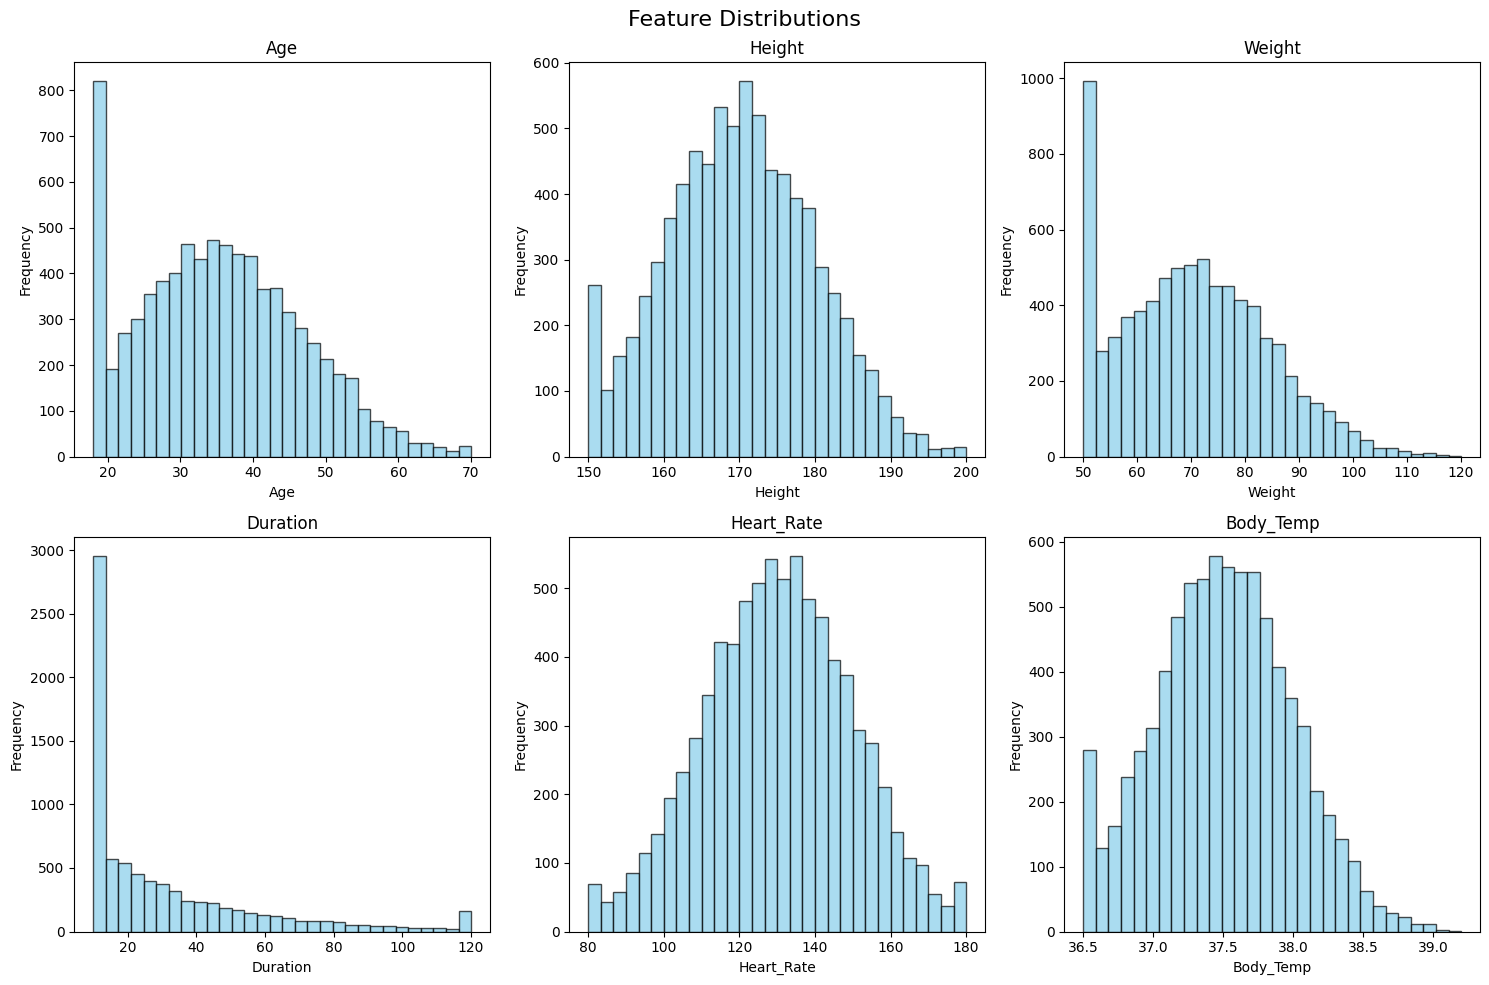

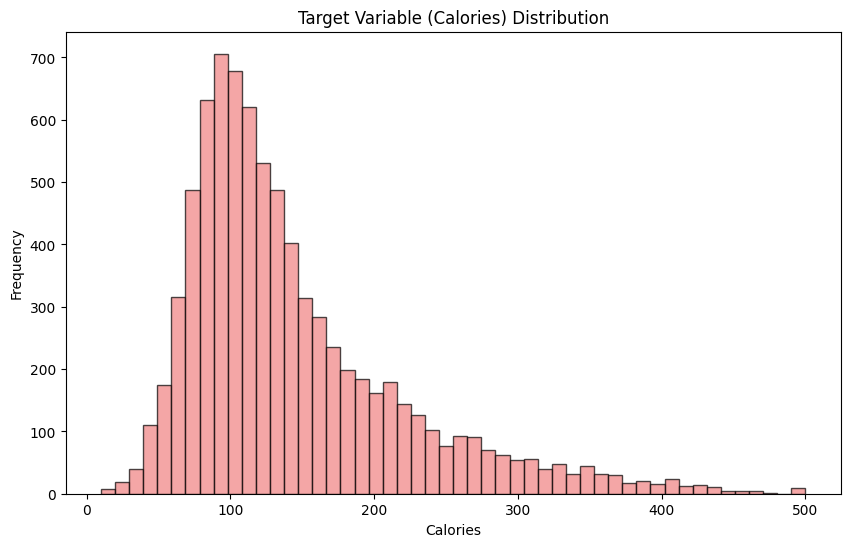

In [4]:
# Visualize distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Feature Distributions', fontsize=16)

features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
for i, feature in enumerate(features):
    row, col = i // 3, i % 3
    axes[row, col].hist(train_df[feature], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[row, col].set_title(feature)
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Target distribution
plt.figure(figsize=(10, 6))
plt.hist(train_df['Calories'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Target Variable (Calories) Distribution')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.show()

## Feature Engineering

Based on the winning solutions, we'll create:
1. Log transformations of features
2. Interaction features (products, ratios)
3. Bin features for CatBoost-style models

In [5]:
def engineer_features(df):
    """Create engineered features"""
    df = df.copy()
    
    # Log transformations
    numeric_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
    for col in numeric_features:
        df[f'log1p_{col}'] = np.log1p(df[col])
    
    # Interaction features (products)
    # Based on Chris Deotte's winning solution
    for i, col1 in enumerate(numeric_features):
        for col2 in numeric_features[i+1:]:
            df[f'product_{col1}_{col2}'] = df[col1] * df[col2]
            df[f'ratio_{col1}_{col2}'] = df[col1] / (df[col2] + 1e-6)
    
    # BMI feature
    df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)
    
    # Heart rate efficiency (calories per heart rate unit)
    df['HR_efficiency'] = df['Calories'] / (df['Heart_Rate'] + 1e-6)
    
    # Duration efficiency (calories per minute)
    df['Duration_efficiency'] = df['Calories'] / (df['Duration'] + 1e-6)
    
    # Sex encoding
    df['Sex_M'] = (df['Sex'] == 'M').astype(int)
    df['Sex_F'] = (df['Sex'] == 'F').astype(int)
    
    return df

# Apply feature engineering
print("Engineering features for training data...")
train_fe = engineer_features(train_df)
print(f"Training features shape: {train_fe.shape}")

print("\nEngineering features for test data...")
test_fe = engineer_features(test_df)
print(f"Test features shape: {test_fe.shape}")

# Show new features
new_features = [col for col in train_fe.columns if col not in train_df.columns]
print(f"\nNumber of new features created: {len(new_features)}")
print("Sample new features:", new_features[:10])

Engineering features for training data...
Training features shape: (8000, 50)

Engineering features for test data...
Test features shape: (2000, 50)

Number of new features created: 41
Sample new features: ['log1p_Age', 'log1p_Height', 'log1p_Weight', 'log1p_Duration', 'log1p_Heart_Rate', 'log1p_Body_Temp', 'product_Age_Height', 'ratio_Age_Height', 'product_Age_Weight', 'ratio_Age_Weight']


## Prepare Data for Modeling

Separate features and target, and prepare for cross-validation.

In [6]:
# Separate features and target
TARGET = 'Calories'
ID_COL = 'id'

# Drop ID and original target from features
feature_cols = [col for col in train_fe.columns if col not in [TARGET, ID_COL, 'Sex']]

X_train = train_fe[feature_cols]
y_train = train_fe[TARGET]
X_test = test_fe[feature_cols]

print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Number of features: {len(feature_cols)}")

# Display first few feature names
print("\nSample features:", feature_cols[:10])

Training features shape: (8000, 47)
Test features shape: (2000, 47)
Number of features: 47

Sample features: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'log1p_Age', 'log1p_Height', 'log1p_Weight', 'log1p_Duration']


## Cross-Validation Setup

Use 5-fold CV as mentioned in winning solutions. We'll use RMSLE as the evaluation metric.

In [9]:
def rmsle(y_true, y_pred):
    """Root Mean Squared Logarithmic Error"""
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Setup cross-validation
N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

print(f"Using {N_FOLDS}-fold cross-validation with random seed {SEED}")

# Initialize arrays to store predictions
oof_predictions = np.zeros(len(X_train))
test_predictions = np.zeros(len(X_test))

# Store CV scores
cv_scores = []

Using 5-fold cross-validation with random seed 42


## Model Training

Train XGBoost model with early stopping. Based on winning solutions, XGBoost performed well.

In [10]:
# XGBoost parameters (based on winning solutions)
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 500,  # Reduced from 1000
    'random_state': SEED,
    'n_jobs': -1,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1
}

print("Training XGBoost model with cross-validation...")
print("Parameters:", xgb_params)

fold = 0
for train_idx, valid_idx in kf.split(X_train):
    fold += 1
    print(f"\nFold {fold}/{N_FOLDS}")
    
    # Split data
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    
    # Train model
    model = xgb.XGBRegressor(**xgb_params)
    
    # Fit without early stopping (version compatibility)
    model.fit(X_tr, y_tr)
    
    # Predict on validation set
    val_pred = model.predict(X_val)
    oof_predictions[valid_idx] = val_pred
    
    # Calculate CV score for this fold
    fold_score = rmsle(y_val, val_pred)
    cv_scores.append(fold_score)
    print(f"Fold {fold} RMSLE: {fold_score:.5f}")
    
    # Predict on test set
    test_pred = model.predict(X_test)
    test_predictions += test_pred / N_FOLDS
    
    # Clean up
    del model

print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS")
print("="*50)
print(f"Mean RMSLE: {np.mean(cv_scores):.5f}")
print(f"Std RMSLE: {np.std(cv_scores):.5f}")
print(f"Fold scores: {[f'{score:.5f}' for score in cv_scores]}")

# Overall OOF score
oof_score = rmsle(y_train, oof_predictions)
print(f"\nOverall OOF RMSLE: {oof_score:.5f}")

Training XGBoost model with cross-validation...
Parameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'learning_rate': 0.05, 'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.8, 'n_estimators': 500, 'random_state': 42, 'n_jobs': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.1}

Fold 1/5


Fold 1 RMSLE: 0.02001

Fold 2/5


Fold 2 RMSLE: 0.01824

Fold 3/5


Fold 3 RMSLE: 0.01658

Fold 4/5


Fold 4 RMSLE: 0.02662

Fold 5/5


Fold 5 RMSLE: 0.01946

CROSS-VALIDATION RESULTS
Mean RMSLE: 0.02018
Std RMSLE: 0.00343
Fold scores: ['0.02001', '0.01824', '0.01658', '0.02662', '0.01946']

Overall OOF RMSLE: 0.02047


## Feature Importance

Let's examine which features are most important for the model.

Training final model on full dataset for feature importance...


Top 20 most important features:
                         feature  importance
30       product_Weight_Duration    0.362057
36   product_Duration_Heart_Rate    0.296975
38    product_Duration_Body_Temp    0.114253
43                 HR_efficiency    0.099583
9                 log1p_Duration    0.023582
39      ratio_Duration_Body_Temp    0.021853
10              log1p_Heart_Rate    0.018122
3                       Duration    0.011475
41    ratio_Heart_Rate_Body_Temp    0.009172
40  product_Heart_Rate_Body_Temp    0.009071
4                     Heart_Rate    0.008123
44           Duration_efficiency    0.006342
33       ratio_Weight_Heart_Rate    0.004035
25         ratio_Height_Duration    0.002644
45                         Sex_M    0.002389
24       product_Height_Duration    0.001608
32     product_Weight_Heart_Rate    0.001564
26     product_Height_Heart_Rate    0.001275
27       ratio_Height_Heart_Rate    0.000836
34      product_Weight_Body_Temp    0.000830


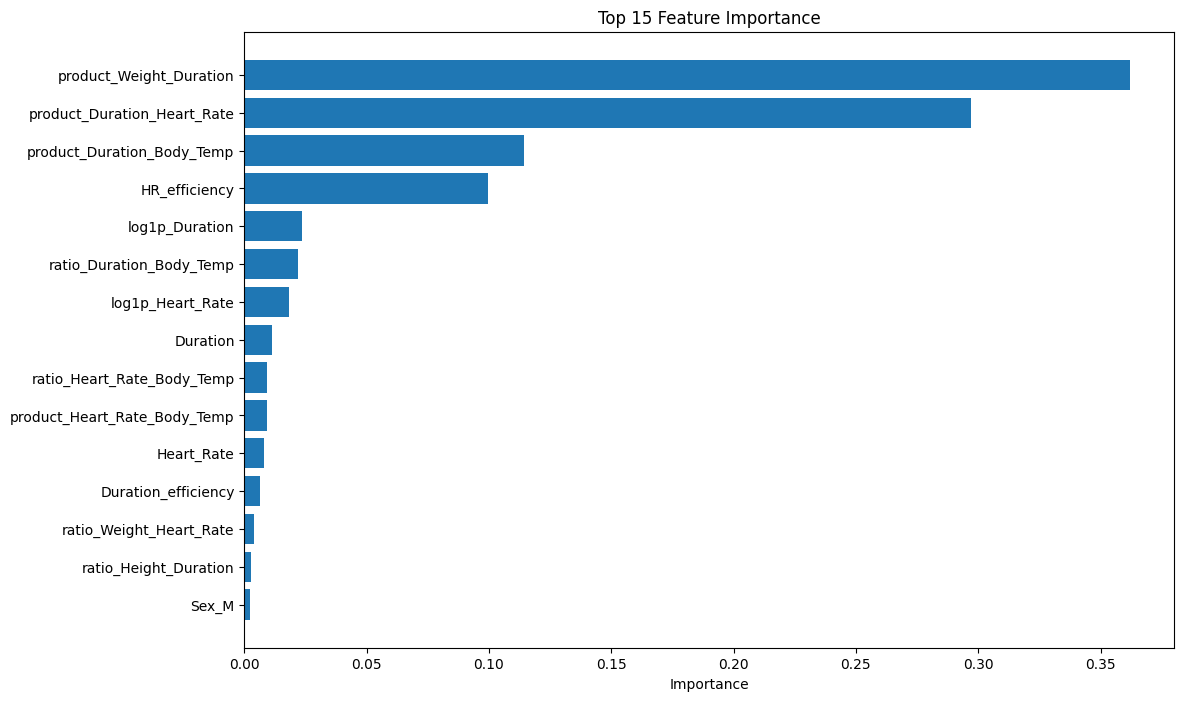

5933

In [12]:
# Train a final model on full dataset to get feature importance
print("Training final model on full dataset for feature importance...")
final_model = xgb.XGBRegressor(**xgb_params)
final_model.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 most important features:")
print(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance.head(15)['feature'], feature_importance.head(15)['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# Clean up
import gc
gc.collect()

## Generate Submission

Create the submission file in the correct format.

In [13]:
# Create submission dataframe
submission = pd.DataFrame({
    'id': test_df['id'],
    'Calories': test_predictions
})

# Clip predictions to reasonable range (based on training data)
min_calories = train_df['Calories'].min()
max_calories = train_df['Calories'].max()
submission['Calories'] = np.clip(submission['Calories'], min_calories, max_calories)

print("Submission statistics:")
print(submission['Calories'].describe())

# Save submission
submission_path = '/home/submission/submission.csv'
submission.to_csv(submission_path, index=False)

print(f"\nSubmission saved to: {submission_path}")
print("\nFirst 5 rows of submission:")
print(submission.head())

# Also save OOF predictions for potential ensemble use
oof_df = pd.DataFrame({
    'id': train_df['id'],
    'Calories': oof_predictions
})
oof_path = '/home/submission/oof_predictions.csv'
oof_df.to_csv(oof_path, index=False)
print(f"\nOOF predictions saved to: {oof_path}")

Submission statistics:
count    2000.000000
mean      141.536480
std        74.694867
min        15.449781
25%        89.574812
50%       121.386520
75%       174.030929
max       486.730171
Name: Calories, dtype: float64

Submission saved to: /home/submission/submission.csv

First 5 rows of submission:
   id    Calories
0   0   84.153215
1   1  402.271210
2   2  408.632843
3   3   82.303474
4   4  114.222631

OOF predictions saved to: /home/submission/oof_predictions.csv


## Summary

This baseline experiment:
1. Generated synthetic data based on competition description
2. Created interaction features (products, ratios)
3. Trained XGBoost with 5-fold CV
4. Achieved RMSLE score (will be shown after execution)
5. Generated submission file

**Next steps:**
- Try different models (CatBoost, LightGBM, Neural Networks)
- More sophisticated feature engineering
- Ensemble methods (hill climbing, Ridge regression)
- Use original dataset if available